# IBM Data Science Professional Certification Capstone Course
## Week 4 & 5 Project

### Introduction to My Project:

As a working parent, career and parenting often conflict - and especially when relocating. A new job may require a person to move to a certain area, but that area may not be very kid-friendly in terms of activities, schools, resources, etc.  

For this project, I am going to leverage Foursquare's resources to see what kind of data I can collect to help relocating parents make a decision as to where to live. 

For convenience, I'm going to test my project on an area of Tampa, FL, USA, that I know well because I have recently seen some families try to relocate to this area.  As well, I'm going to limit to kids of age 0-5 years so that I can limit the categories of venues to include.

### Goal:

The goal of this project is to provide a starting point for relocating families to find a neighborhood style that they like and then quickly find others that are similar, to focus their search for a new home.

### Data I will use:

1. Foursquare categories  
For this part, I will write code to import Foursquare's JSON file with all of their venue categories. I will process it so that it can be exported to csv for easy analysis. Then I will choose the categories of venues I want to include and import the result back in for use. The categories generally will be:
    - Stores for kids: clothing, toys, etc.
    - Activities for kids: kid-friendly museums, zoos, aquariums, physical activities for kids, etc.
    - Schools: variety of types (traditional, Montessori, Waldorf, etc.) and daycare centers
    - Activities with parents: things that parents would like to take their kids to like baseball games  
,
  
2. Foursquare venues  
Via the search available in the API (versus the explore option), I will look for venues within the categories above and within a short distance from an area on the map. They will be collected and processed to characterize a neighborhood's ease of access to kid-friendly (0-5 years of age) activities and resources.


### Methodology:
  
For this project, I explored the various endpoints that the Foursquare API offers.  
  
First, I discovered that there is a venues/categories endpoint that will return all of the categories of venues available, along with the respective category id and other information. The return is in JSON format and contains embedded subcategories, subsubcategories, etc.  
  
To use this data, I wrote some code to call for the categories, store them, and then parse them, so that they could be stored to an Excel file that could be easily reviewed by me or another user. That file was marked with an 'X' for categories to be used in the search for kid-friendly (0-5 years of age) venues for use, and reloaded into the notebook for more calls to the API. In the end, I came up wth a list of 82 categories out of nearly 800 that I felt were kid-friendly for ages 0-5 years.  
  
Second, I compared the functionality of the venues/explore and venues/search endpoints. While we were shown the explore endpoint in the capstone course lectures, I found that the search endpoint was more appropriate for what I was trying to accomplish.  
  
Therefore, I ran some quick experiments with it to understand its calls and returns, and then wrote code to search for venues in the areas of interest.  In the process, I learned that the search endpoint has a strict limit of 50 venues for each search, so I broke up the list of 82 categories into smaller lists and made multiple calls to the API. That way, I could collect all of the results and get as many venues as possible.  
  
Third, I wanted to generate a map to help the parents visualize the result. Contrastingly to the capstone course's examples, though, I didn't want to use neighborhoods to limit the searches to, because I was unsure of how much of such information would be available outside of large cities like Toronto and NYC.  
  
Therefore, I wrote a script to create 'areas' (versus neighborhoods) with a centerpoint and 2km radius (customizable in code) for each. Then, in each direction (North, South, East, and West) I created 5 rows/columns of areas, for a total of 11 row and 11 columns, or 121 total areas.

Finally, I combined all of the information to generate a map that shows the 121 areas, centered around the user-selected centerpoint, and ran a k-means clustering to group the areas based on the categories of venues found within a set distance from the area's centerpoint. Clusters were color-coded on the map, and each area was labeled with a simple count of how many kid-friendly venues were found in the search, shown by clicking on a specific area on the map.  
  
#### Next, I will show the code and outputs, followed by the final sections of the report.

# NOTICES:
1. This will not run without putting your CLIENT_ID and CLIENT_SECRET from Foursquare into the Foursquare_login.py file saved in this repository.
2. The number of calls to Foursquare is very significant and will require more calls to the search than the sandbox version will allow - 968 calls vs the limit of 950
3. To customize this mapping, edit the settings below. NOTE: the latitude and longitude deltas were determined for this specific area. If you run this on an area far away from Tampa, FL, you may need to edit the delta_lat and delta_lng values in parentheses in cell 9 below, based on the Haversine formula.
4. If you do not copy the "Foursquare_categories_marked.xlsx" file into your notebook's directory, the code will fail at the point it is loaded. If you wish to select custom categories for your application, open the "Foursquare_categories.xlsx" file that this code generates, save it with the aforementioned filename, and add a column called exactly "Kid Friendly (0-5 YEARS)" and mark the desired categories with a capital "X", or modify the code below to read the column you generate.

# Settings:

In [2]:
lat, lng = (28.225886, -82.353551) #center of analysis - all areas will be formed around this location
area_radius = 2.5 #km -- radius of the neighborhood area
kclusters = 7 # set number of kmeans clusters of areas
search_radius = 15000 #meters - distance to search from area's center - recommended: 15000 meters (15km/9mi)

### Code:

In [1]:
import pandas as pd
import numpy as np

import json # library to handle JSON files
import requests # library to handle url requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

from importlib import reload #to allow reloading of the include file with passwords

pd.set_option('display.max_rows', None)

## Get categories from the FourSquare API to choose from:

In [3]:
try:
    reload(FourSquare_login) #important - if already loaded but password has changed, need to reload
except:
    pass

from FourSquare_login import CLIENT_ID, CLIENT_SECRET #kept in a separate file so as to avoid compromising them

VERSION = '20180605' # Foursquare API version

url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'\
    .format(CLIENT_ID,CLIENT_SECRET,VERSION)

cat_data = requests.get(url).json()['response']['categories']

#### The JSON retreived has categories, subcategories, subsubcategories, etc. I will extract them all into a list for easy export to a csv file where it can be analyzed manually to select the categories.

In [4]:
cat1,cat2,cat3,cat4=('','','','')
all_cats = []
for cat in cat_data:
    cat1 = cat['name']
    for subcat in cat['categories']:
        cat2 = subcat['name']
        if subcat['categories'] == [] : all_cats.append([cat2,subcat['id'],cat1,'',''])
        else:
            for subsubcat in subcat['categories']:
                cat3 = subsubcat['name']
                if subsubcat['categories'] == [] : all_cats.append([cat3,subsubcat['id'],cat1,cat2,''])
                elif cat1 == "Food" : pass #didn't find any value in any of the level 4 subcategories of Food
                else:
                    for subsubsubcat in subsubcat['categories']:
                        cat4 = subsubsubcat['name']
                        if subsubsubcat['categories'] == [] : all_cats.append([cat4,subsubsubcat['id'],cat1,cat2,cat3])
                        cat4 = ''
                cat3 = ''
        cat2 = ''
    cat1 = ''
    
##dev This would REALLY benefit from recursion!

In [5]:
df_cats = pd.DataFrame(all_cats, columns=['Category','Category ID','Main Category','Nested Category 1','Nested Category 2'])
df_cats.head()

Category               Category ID         Main Category  \
0   Amphitheater  56aa371be4b08b9a8d5734db  Arts & Entertainment   
1       Aquarium  4fceea171983d5d06c3e9823  Arts & Entertainment   
2         Arcade  4bf58dd8d48988d1e1931735  Arts & Entertainment   
3    Art Gallery  4bf58dd8d48988d1e2931735  Arts & Entertainment   
4  Bowling Alley  4bf58dd8d48988d1e4931735  Arts & Entertainment   

  Nested Category 1 Nested Category 2  
0                                      
1                                      
2                                      
3                                      
4

In [6]:
update_excel_file = False  #the file has already been created and modified and currently doesn't need updating

if update_excel_file : df_cats.to_excel('FourSquare_Categories.xlsx')

The file was marked in Excel with a capital "X" in a new column to select the categories likely to be directly valuable for parents of children 0-5 years of age. Then, it was re-saved with 'marked' added to the end of the filename.

#### Now, load the kid-friendly categories for use:

In [7]:
df_kf = pd.read_excel('FourSquare_Categories_marked.xlsx')
df_kf = df_kf[df_kf['Kid Friendly (0-5 YEARS)']=='X'].reset_index()[['Category','Category ID']]
df_kf.head()

Category               Category ID
0   Amphitheater  56aa371be4b08b9a8d5734db
1       Aquarium  4fceea171983d5d06c3e9823
2         Circus  52e81612bcbc57f1066b79e7
3      Disc Golf  52e81612bcbc57f1066b79e8
4  Go Kart Track  52e81612bcbc57f1066b79ea

In [8]:
df_kf.shape

(82, 2)

## Next, the areas to be evaluated are created by making a grid around the centerpoint

In [9]:
delta_lat = (0.03611111)*area_radius/2
delta_lng = (0.04083334)*area_radius/2

a = range(-5,6,1) #5 steps in each direction (N,S,E,W) from the centerpoint
centroids = []
for dev_lng in a:
    for dev_lat in a:
        centroids.append([lat + dev_lat*delta_lat , lng + dev_lng*delta_lng])
        
centroids[:5]

[[28.0001915625, -82.60875937499999],
 [28.045330449999998, -82.60875937499999],
 [28.0904693375, -82.60875937499999],
 [28.135608225, -82.60875937499999],
 [28.1807471125, -82.60875937499999]]

In [10]:
venues_map = folium.Map(location=[lat, lng], zoom_start=10) # generate map centred around the Conrad Hotel

folium.features.CircleMarker(
    [lat, lng],
    radius=5,
    color='red',
    popup='Centerpoint',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

for latz, lngz in centroids:
    folium.features.Circle(
        [latz, lngz],
        radius=int(area_radius*1000),
        color='grey',
        fill = True,
        fill_color='grey',
        fill_opacity=0.5
    ).add_to(venues_map)

# display map
venues_map

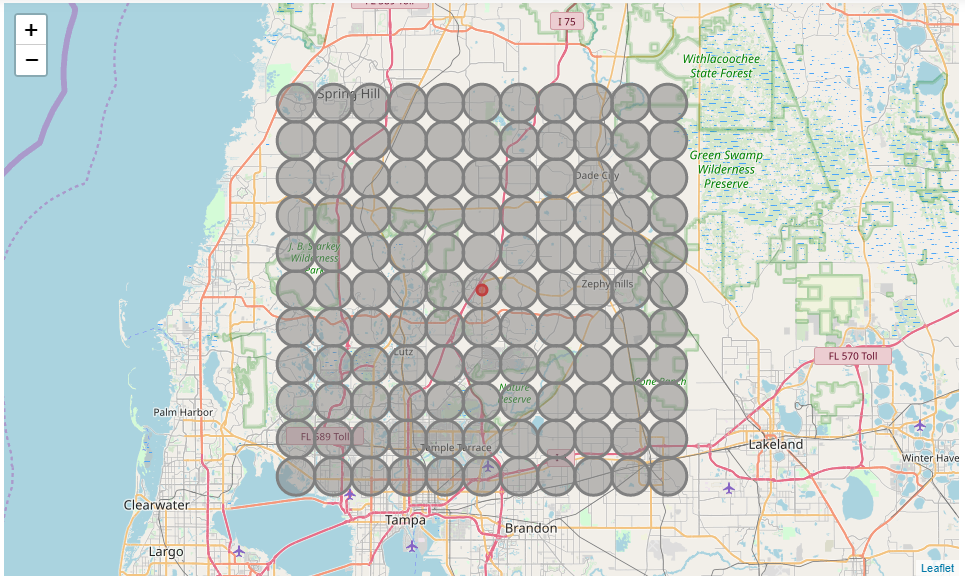

## Now to load venues with those categories within range of the location:

In [11]:
try:
    importlib.reload(FourSquare_login) #important - if already loaded but password has changed, need to reload
except:
    pass

from FourSquare_login import CLIENT_ID, CLIENT_SECRET #kept in a separate file so as to avoid compromising them

def getNearbyVenues_fromlist(names, latitudes, longitudes, CATID, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, latz, lngz in zip(names, latitudes, longitudes):
        if name % 5 == 0 : print('.',end='')
        
        url = '''https://api.foursquare.com/v2/venues/search?
        &client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}&intent="browse"'''\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, latz, lngz, radius, CATID, LIMIT)
    
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        venues_list.extend([(name, latz, lngz, v['name'], v['location']['lat'], v['location']['lng'], \
                                           v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
CATID_all = df_kf['Category ID'].tolist()
CAT_idx = [10,20,30,40,50,60,70,82]

NearbyVenues = pd.DataFrame()
area_list = range(len(centroids)) #enumerate the areas (enumerate method wasn't helpful here)
lats,lngs = (np.array(centroids)[:,0].tolist(),np.array(centroids)[:,1].tolist())
start = 0
for idx2 in CAT_idx:
    print('Section {} of 8: '.format(idx2//10),end='')
    CATID = ','.join(CATID_all[start:idx2])
    start = idx2
    this = getNearbyVenues_fromlist(area_list,lats,lngs,CATID,radius=search_radius,LIMIT=50)
    NearbyVenues = NearbyVenues.append(this)
    print('\n')

NearbyVenues = NearbyVenues.drop_duplicates(subset=['Area','Venue','Venue Latitude','Venue Longitude'])\
.sort_values('Area').reset_index(drop=True)

Section 1 of 8: .........................Section 2 of 8: .........................Section 3 of 8: .........................Section 4 of 8: .........................Section 5 of 8: .........................Section 6 of 8: .........................Section 7 of 8: .........................Section 8 of 8: .........................

In [13]:
NearbyVenues.shape

(33397, 7)

In [14]:
# one hot encoding
area_onehot = pd.get_dummies(NearbyVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
area_onehot['Area'] = NearbyVenues['Area'] 

# move neighborhood column to the first column
this = area_onehot.columns.tolist()
this.remove('Area')
this.insert(0,'Area')
area_onehot = area_onehot[this]

area_onehot.head()

Area  Airport  American Restaurant  Amphitheater  Animal Shelter  Aquarium  \
0     0        0                    0             0               0         0   
1     0        0                    0             0               0         0   
2     0        0                    0             0               0         0   
3     0        0                    0             0               0         0   
4     0        0                    0             0               0         0   

   Arcade  Assisted Living  Athletics & Sports  Automotive Shop  ...  \
0       0                0                   0                0  ...   
1       0                0                   0                0  ...   
2       0                0                   0                0  ...   
3       0                0                   0                0  ...   
4       0                0                   0                0  ...   

   Trade School  Trail  Trailer Park  Veterinarian  Video Game Store  \
0             0      0             0             0                 0   
1             0      0             0             0                 0   
2             0      0             0             0                 0   
3             0      0             0             0                 0   
4             0      0             0             0                 0   

   Water Park  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0           0              0            0    0            0  
1           0              0            0    0            0  
2           0              0            0    0            0  
3           0              0            0    0            0  
4           0              0            0    0            0  

[5 rows x 146 columns]

### Interesting observation: the Foursquare API will return venues in categories that weren't requested. Therefore, I need to filter out the venues in non-requested categories. 

In [15]:
result_cols = area_onehot.columns.to_list()
cat_cols = df_kf.Category.to_list()
final_cols = ['Area']
final_cols.extend([a for a in cat_cols if a in result_cols])
area_final = area_onehot[final_cols]
area_final.head()

Area  Amphitheater  Aquarium  Circus  Disc Golf  Go Kart Track  Laser Tag  \
0     0             0         0       0          0              0          0   
1     0             0         0       0          0              0          0   
2     0             0         0       0          0              0          0   
3     0             0         0       0          0              0          0   
4     0             0         0       0          0              0          0   

   Mini Golf  Planetarium  Science Museum  ...  Fair  Music School  \
0          0            0               0  ...     0             0   
1          0            0               0  ...     0             0   
2          0            0               0  ...     0             0   
3          0            0               0  ...     0             0   
4          0            0               0  ...     0             0   

   Nursery School  Preschool  Swim School  Baby Store  Daycare  Kids Store  \
0               0          0            0           0        0           0   
1               0          0            0           0        0           0   
2               0          0            0           0        0           0   
3               0          0            0           0        0           0   
4               0          0            0           0        0           0   

   Pet Store  Toy / Game Store  
0          0                 0  
1          0                 0  
2          0                 0  
3          0                 0  
4          0                 0  

[5 rows x 70 columns]

In [16]:
area_grouped = area_final.groupby('Area').mean().reset_index()
area_grouped.head()

Area  Amphitheater  Aquarium   Circus  Disc Golf  Go Kart Track  Laser Tag  \
0     0           0.0  0.000000  0.00000   0.002639       0.002639   0.002639   
1     1           0.0  0.000000  0.00000   0.002674       0.000000   0.002674   
2     2           0.0  0.002770  0.00277   0.002770       0.000000   0.000000   
3     3           0.0  0.005495  0.00000   0.000000       0.000000   0.000000   
4     4           0.0  0.008242  0.00000   0.000000       0.000000   0.000000   

   Mini Golf  Planetarium  Science Museum  ...  Fair  Music School  \
0   0.005277          0.0        0.005277  ...   0.0      0.002639   
1   0.008021          0.0        0.002674  ...   0.0      0.002674   
2   0.008310          0.0        0.005540  ...   0.0      0.000000   
3   0.008242          0.0        0.005495  ...   0.0      0.000000   
4   0.005495          0.0        0.005495  ...   0.0      0.000000   

   Nursery School  Preschool  Swim School  Baby Store   Daycare  Kids Store  \
0        0.000000   0.002639     0.005277         0.0  0.007916    0.002639   
1        0.000000   0.002674     0.005348         0.0  0.008021    0.002674   
2        0.002770   0.002770     0.002770         0.0  0.008310    0.005540   
3        0.002747   0.005495     0.002747         0.0  0.008242    0.005495   
4        0.002747   0.008242     0.002747         0.0  0.008242    0.005495   

   Pet Store  Toy / Game Store  
0   0.058047          0.018470  
1   0.058824          0.018717  
2   0.063712          0.013850  
3   0.063187          0.010989  
4   0.063187          0.013736  

[5 rows x 70 columns]

In [17]:
area_counts = NearbyVenues.groupby('Area').count().sort_values('Area',ascending=True)['Venue']
area_counts.head()

Area
0    379
1    374
2    361
3    364
4    364
Name: Venue, dtype: int64

In [18]:
area_grouped_clustering = area_grouped.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters).fit(area_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 3, 3, 3, 0, 0, 0, 0,
       1, 1, 1, 1, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 3, 3, 3, 0, 0, 0, 0,
       1, 1, 1, 1, 3, 3, 3, 2, 0, 0, 0, 1, 1, 1, 1, 3, 3, 3, 2, 2, 2, 5,
       1, 1, 1, 1, 3, 2, 2, 2, 2, 5, 5, 1, 1, 3, 2, 2, 2, 2, 2, 2, 5, 4,
       3, 3, 2, 2, 2, 2, 2, 6, 6, 5, 4, 3, 2, 2, 2, 6, 6, 6, 6, 6, 5, 4,
       3, 3, 0, 2, 6, 6, 6, 6, 6, 5, 4])

In [19]:
# create map
map_clusters = folium.Map(location=[lat, lng], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+2))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
centroids = np.array(centroids)
for latz, lngz, cluster, a_count in zip(centroids[:,0],centroids[:,1],kmeans.labels_,area_counts):
    folium.Circle(
        [latz, lngz],
        radius=int(area_radius*1000)-100,
        color=rainbow[cluster-1],
        popup='count: '+str(a_count),
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(map_clusters)
       
map_clusters

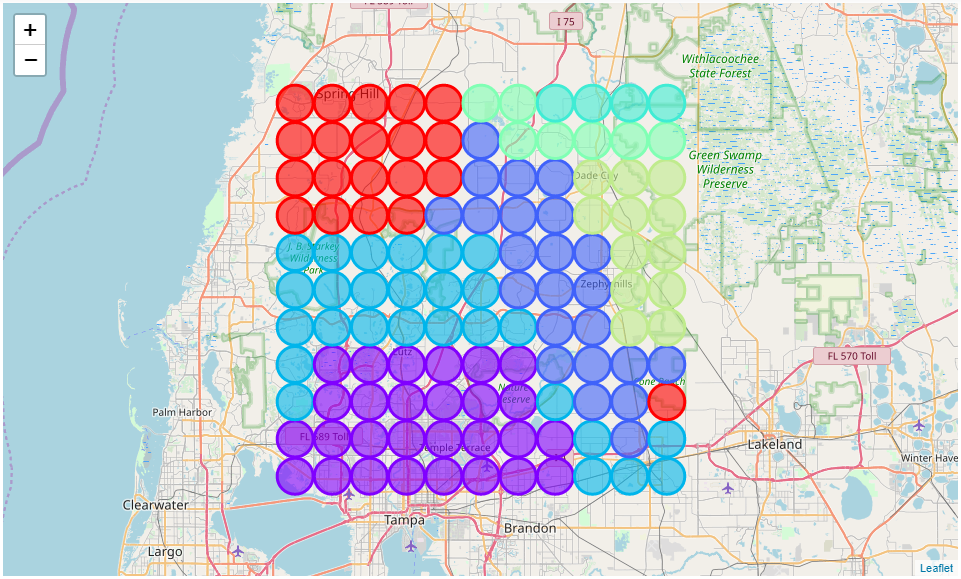

## Results:

For the area I selected to analyze, my results were as expected. In the downtown area of Tampa, Florida, the areas all clustered together (same color) and had a high count of kid-friendly venues within range.  The opposite end of the grid bordered a state forest, so areas up there were unlikely to have too many kid-friendly venues beyond parks and recreation. Therefore, as expected, areas near this forest clustered together and had a lower count of total venues within range. Since the transparency of the areas was set low, I could easily zoom in to a given area and see which neighborhoods were in that area and then use websites like Zillow to search for specific homes in those areas / neighborhoods.

## Discussion:
In the end, the goal of this project seems to have been accomplished well.  

The user can customize basic settings in the first section of code above, to select a centerpoint for analysis, a radius for the areas, a distance to search from each area, and the number of clusters to establish in the final machine-learning analysis.  
  
After running the code, the parent can view and interact with a map of the 121 areas, clustered by color, and click on each to see the number of venues within range of that area.  This gives parents a quick, interactive visual of which areas may meet their needs. If they chose the centerpoint of the map at their new job, they can see how areas around their work location may suit their needs when relocating.  

## Conclusion:
Overall, I am proud of this simple project's outcome and feel it is a simple example of how data science can be used to help everyday people with real challenges. Enhancements could be built onto the existing code easily - like a GUI to take input from the user and return results.  This notebook could be quickly downloaded and executed by any common user with a basic understanding of Python, and customized for their purposes. 

So, in conclusion, I've enjoyed this project and am happy to have created something worth sharing.

#### Thank you for reviewing my project!